In [1]:
import pandas as pd
import numpy as np

pd.options.display.float_format = '{:.2f}%'.format

## Exploration of the identifier and demographic-1 features

- **identifier** features
    - **encounter_id**: Unique, non-repeating values. 
    - **hospital_id-icu_id**: A patient diagnosed with Diabetus Mellitus should not depend on hospital_id & it's icu_id. Each hostpital will have unique icu_ids. **DROP**
- **demographic-1** features
    - age, height, weight, bmi, gender, ethnicity
    - **readmission_status**: is 0 for all rows. **DROP**
    - Compare the training and test datasets
    - Compare values in the training set where the dm=1 and dm=0
- **demographic-2** features *TODO*
    - readmission_status, elective_surgery, ....
- **labs & vitals category**: *TODO*
    - They have max and min values. Should these be replaced with average?



## Common Functions

In [2]:
def _describe(df, df_type):
    m_total = 'Entries - Total:'
    m_features = "Features:"

    print("-"*40)
    print(f"{df_type} dataset - details")
    print("-"*40)
    print(f"{m_total:33} {df.shape[0]:6}")

    df_dm_1 = df_dm_0 = pd.DataFrame()
    if df_type != "Testing":
        df_dm_1  = df[df['diabetes_mellitus']==1]; df_dm_1.to_csv(f"{df_type}_dm_1.csv")
        df_dm_0  = df[df['diabetes_mellitus']==0]; df_dm_0.to_csv(f"{df_type}_dm_0.csv")
        print(f"Entries - diabetes_mellitus = 1: {df_dm_1.shape[0]:7} {100 * df_dm_1.shape[0]/df.shape[0]:0.2f}%")
        print(f"Entries - diabetes_mellitus = 0: {df_dm_0.shape[0]:7} {100 * df_dm_0.shape[0]/df.shape[0]:0.2f}%")
    print(f"{m_features:33} {len(df.columns):6}")
    return df.shape[0], df_dm_1, df_dm_0


In [3]:
def _nullcheck(df):
    for col in ['age', 'gender', 'ethnicity', 'weight', 'height', 'bmi']:
        print(f"{col:10}: {df[df[col].isnull()].shape[0]:4}")
        
    print("readmission_status", df_train['readmission_status'].unique())

In [4]:
def _nullcheck_bmi(df):
    df_bmi = df[['weight', 'height', 'bmi', 'age', 'gender', 'ethnicity']]
    print("Number of rows where either weight or height or both are null", 
            df_bmi[ df_bmi['height'].isnull() & df_bmi['weight'].notnull() |
            df_bmi['height'].notnull() & df_bmi['weight'].isnull() |
            df_bmi['height'].isnull() & df_bmi['weight'].isnull()].shape[0])
    print("Number of rows where bmi is null",  df_bmi[ df_bmi['bmi'].isnull()].shape[0])

    print(f"Rows with Weight=null Height=!null BMI=!null {df_bmi[df_bmi['weight'].isnull() & df_bmi['height'].isnull() & df_bmi['bmi'].notnull()].shape[0]}")
    print(f"Rows with Weight=!null Height=null BMI=!null {df_bmi[df_bmi['weight'].notnull() & df_bmi['height'].isnull() & df_bmi['bmi'].notnull()].shape[0]}")
    print(f"Rows with Weight=null Height=!null BMI=!null {df_bmi[df_bmi['weight'].isnull() & df_bmi['height'].notnull() & df_bmi['bmi'].notnull()].shape[0]}")
    print(f"Rows with Weight=!null Height=!null BMI=null {df_bmi[df_bmi['weight'].notnull() & df_bmi['height'].notnull() & df_bmi['bmi'].isnull()].shape[0]}")

    df_bmi = df_bmi[df_bmi['bmi'].isnull()]
    print("bmi=null", df_bmi.shape[0])
    rows_dep = df_bmi[df_bmi['age'].notnull() & df_bmi['ethnicity'].notnull() & df_bmi['gender'].notnull()].shape[0]
    print(df_bmi.shape[0], rows_dep, df_bmi.shape[0]-rows_dep)
    print("Atleast one dependent column is null:", df_bmi[df_bmi['age'].isnull() | df_bmi['ethnicity'].isnull() | df_bmi['gender'].isnull()].shape[0])
    print("Age: null, Ethnicity:!null, Gender:!null:", df_bmi[df_bmi['age'].isnull() & df_bmi['ethnicity'].notnull() & df_bmi['gender'].notnull()].shape[0])
    print("All dependent columns are null:", df_bmi[df_bmi['age'].isnull() & df_bmi['ethnicity'].isnull() & df_bmi['gender'].isnull()].shape[0])
    df_bmi[df_bmi['age'].isnull() | df_bmi['ethnicity'].isnull() | df_bmi['gender'].isnull()].to_csv("bmi_null.csv")

In [5]:
def AGE_BINS(df):
      return pd.cut(df['age'], [-0.1, 0, 15.9, 20, 40, 60, 90, 120])

def _agedist(df, df_name):
    total_count = df.shape[0]
    nan_count = df[df['age'].isnull()].shape[0]
    nan_pc = nan_count/total_count

    ages = df['age'].unique()
    ages.sort()
    # Since age has 0.0 values, these should be ignored/replaced
    min_age = ages[1]
    print(f"Invalid age: {df[df['age']==0.0]['age'].count()} Min: {df['age'].min():0.2f} Max: {df['age'].max():0.2f}")

    # Group the ages based on the age-groups
    #bins = pd.cut(df['age'], AGE_BINS)
    df_age = df.groupby(AGE_BINS(df))['age'].agg(['count'])
    df_age = df_age.reset_index()

    

    # Append the null value counts
    df_age = df_age.append(pd.DataFrame([['null', nan_count]], columns = ['age', f'count']))

    # Add a percentage column
    df_age[f'{df_name}_%'] = 100 * df_age['count']/total_count
    df_age = df_age.rename(columns = {'count':f"{df_name}_count"})

    print(df_age)
    print(f"Verification:   {df_name}_count: {df_age[f'{df_name}_count'].sum()} "
          f"{df_name}_%: {df_age[f'{df_name}_%'].sum():0.1f}%")
    return df_age, nan_count, nan_pc

In [6]:
# underweight, normal, overweight, obese
BMI_LABELS = [ '[0.0 - 18.5] underweight',
               '[18.5 - 24.9] normal weight',
               '[25 -  30] over weight',
               '[70  <] obese']

def BMI_BINS(df):
      return pd.cut(df['bmi'], [0, 18.5, 24.9, 30, 70], labels=BMI_LABELS)

def _bmidist(df, df_name):
    total_count = df.shape[0]
    nan_count = df[df['bmi'].isnull()].shape[0]
    nan_pc = nan_count/total_count
    print(f"Min: {df['bmi'].min():0.2f} Max: {df['bmi'].max():0.2f}")

    # Group the values based on the bmi-categories
    #bins = pd.cut(df['bmi'], BMI_BINS, labels=BMI_LABELS)
    df_bmi = df.groupby(BMI_BINS(df))['bmi'].agg(['count'])
    df_bmi = df_bmi.reset_index()

    # Append the null value counts
    df_bmi = df_bmi.append(pd.DataFrame([['null', nan_count]], columns = ['bmi', f'count']))

    # Add a percentage column
    df_bmi[f"{df_name}_%"] = 100 * df_bmi['count']/total_count
    df_bmi = df_bmi.rename(columns = {'count':f"{df_name}_count"})

    print(df_bmi)
    print(f"Verification:   {df_name}_count: {df_bmi[f'{df_name}_count'].sum()} "
          f"{df_name}_%: {df_bmi[f'{df_name}_%'].sum():0.1f}%")
    return df_bmi, nan_count, nan_pc

In [7]:
def _categoricalvardist(df, df_name, catvar, total_count=-1):
    if total_count == -1:
        total_count = df.shape[0]
        
    nan_count = df[df[catvar].isnull()].shape[0]
    nan_pc = nan_count/total_count

    df_catvar = df.groupby([catvar]).count()['encounter_id'].sort_values(ascending=False).reset_index()
    df_catvar = df_catvar.rename(columns = {'encounter_id':'count'})

    # Append the null value counts
    df_catvar = df_catvar.append(pd.DataFrame([['null', nan_count]], columns = [catvar, f'count']))

    # Add a percentage column
    df_catvar[f"{df_name}_%"] = 100 * df_catvar['count']/total_count
    df_catvar = df_catvar.rename(columns = {'count':f"{df_name}_count"})

    print(df_catvar)
    print(f"Verification:   {df_name}_count: {df_catvar[f'{df_name}_count'].sum()} "
          f"{df_name}_%: {df_catvar[f'{df_name}_%'].sum():0.1f}%")
    return df_catvar, nan_count, nan_pc

In [8]:
def _compare(feature, df1, df2, col1, col2):
    df = df1.join(df2.set_index(feature), on=feature)
    print(f"{feature}: {col1}: {df1[f'{col1}'].sum():0.1f}% {col2}: {df2[f'{col2}'].sum():0.1f}%")
    return df

In [9]:
def fillnan(df, col, rep_value):
    df[col].fillna(rep_value, inplace=True)

In [10]:
def fillnan_gender(df): #TODO: Remove
    df['gender'].fillna('Unknown', inplace=True)

In [11]:
def fillnan_ethnicity(df): #TODO: Remove
    df['ethnicity'].fillna('Other/Unknown', inplace=True)

## Training dataset

In [12]:
df_train = pd.read_csv("data/TrainingWiDS2021.csv")
df_train.describe()
print(df_train.columns)

Index(['Unnamed: 0', 'encounter_id', 'hospital_id', 'age', 'bmi',
       'elective_surgery', 'ethnicity', 'gender', 'height',
       'hospital_admit_source',
       ...
       'h1_pao2fio2ratio_max', 'h1_pao2fio2ratio_min', 'aids', 'cirrhosis',
       'hepatic_failure', 'immunosuppression', 'leukemia', 'lymphoma',
       'solid_tumor_with_metastasis', 'diabetes_mellitus'],
      dtype='object', length=181)


In [13]:
train_count, df_train_dm_1, df_train_dm_0 = _describe(df_train, "Training")

----------------------------------------
Training dataset - details
----------------------------------------
Entries - Total:                  130157
Entries - diabetes_mellitus = 1:   28151 21.63%
Entries - diabetes_mellitus = 0:  102006 78.37%
Features:                            181


In [14]:
_nullcheck(df_train)


age       : 4988
gender    :   66
ethnicity : 1587
weight    : 3463
height    : 2077
bmi       : 4490
readmission_status [0]


Fill **Unknown** for missing values in **gender** and **ethnicity**

In [15]:
fillnan(df_train, 'gender', 'Unknown')
fillnan(df_train, 'ethnicity', 'Other/Unknown')
#fillnan_gender(df_train) 
#fillnan_ethnicity(df_train)

NameError: name 'df' is not defined

In [16]:
_nullcheck(df_train)

age       : 4988
gender    :   66
ethnicity : 1587
weight    : 3463
height    : 2077
bmi       : 4490
readmission_status [0]


BMI calculations - relation to diabetes
bmi = weight (kg) / [height (m)]2

Adults:
For adults, the interpretation of BMI does not depend on sex or age. 
For adults 20 years old and older, BMI is interpreted using standard weight status categories.
**BMI	Weight Status**
- Below 18.5	Underweight
- 18.5 – 24.9	Normal or Healthy Weight
- 25.0 – 29.9	Overweight
-  30.0 and Above	Obese

In [17]:
_nullcheck_bmi(df_train)

Number of rows where either weight or height or both are null 4490
Number of rows where bmi is null 4490
Rows with Weight=null Height=!null BMI=!null 0
Rows with Weight=!null Height=null BMI=!null 0
Rows with Weight=null Height=!null BMI=!null 0
Rows with Weight=!null Height=!null BMI=null 0
bmi=null 4490
4490 4099 391
Atleast one dependent column is null: 391
Age: null, Ethnicity:!null, Gender:!null: 177
All dependent columns are null: 1


Wherever either weight or height or both are not available, bmi is also not available.
There are no rows where height and weight are null and bmi is not null.

Strategy for filling missing values for weight and height should be 

TODO: Isn't bmi dependent on gender?

In [18]:
df_train_age, train_age_nan, train_age_nanpc = _agedist(df_train, "train")
df_train_bmi, train_bmi_nan, train_bmi_nanpc = _bmidist(df_train, "train")
df_train_gender, nan_count, nan_pc = _categoricalvardist(df_train, 'train', 'gender')
df_train_ethnicity, nan_count, nan_pc = _categoricalvardist(df_train, 'train', 'ethnicity')

Invalid age: 30 Min: 0.00 Max: 89.00
             age  train_count  train_%
0    (-0.1, 0.0]           30    0.02%
1    (0.0, 15.9]            0    0.00%
2   (15.9, 20.0]         1605    1.23%
3   (20.0, 40.0]        13648   10.49%
4   (40.0, 60.0]        37003   28.43%
5   (60.0, 90.0]        72883   56.00%
6  (90.0, 120.0]            0    0.00%
0           null         4988    3.83%
Verification:   train_count: 130157 train_%: 100.0%
Min: 14.84 Max: 67.81
                           bmi  train_count  train_%
0     [0.0 - 18.5] underweight         5323    4.09%
1  [18.5 - 24.9] normal weight        36015   27.67%
2       [25 -  30] over weight        38010   29.20%
3                [70  <] obese        46319   35.59%
0                         null         4490    3.45%
Verification:   train_count: 130157 train_%: 100.0%
  gender  train_count  train_%
0      M        70518   54.18%
1      F        59573   45.77%
0   null           66    0.05%
Verification:   train_count: 130157 train_%:

### Train - diabetes_mellitus = 1

In [19]:
df_train_dm_1_age, train_dm_1_age_nan, train_dm_1_age_nanpc = _agedist(df_train_dm_1, "train_dm_1")
df_train_dm_1_bmi, train_dm_1_bmi_nan, train_dm_1_bmi_nanpc = _bmidist(df_train_dm_1, "train_dm_1")
df_train_dm_1_gender, train_dm_1_gender_nan, train_dm_1_gender_nanpc = _categoricalvardist(df_train_dm_1, 'train_dm_1', 'gender')
df_train_dm_1_ethnicity, train_dm_1_ethnicity_nan, train_dm_1_ethnicity_nanpc = _categoricalvardist(df_train_dm_1, 'train_dm_1', 'ethnicity')

Invalid age: 3 Min: 0.00 Max: 89.00
             age  train_dm_1_count  train_dm_1_%
0    (-0.1, 0.0]                 3         0.01%
1    (0.0, 15.9]                 0         0.00%
2   (15.9, 20.0]               183         0.65%
3   (20.0, 40.0]              1644         5.84%
4   (40.0, 60.0]              7579        26.92%
5   (60.0, 90.0]             18082        64.23%
6  (90.0, 120.0]                 0         0.00%
0           null               660         2.34%
Verification:   train_dm_1_count: 28151 train_dm_1_%: 100.0%
Min: 14.84 Max: 67.81
                           bmi  train_dm_1_count  train_dm_1_%
0     [0.0 - 18.5] underweight               597         2.12%
1  [18.5 - 24.9] normal weight              5268        18.71%
2       [25 -  30] over weight              7503        26.65%
3                [70  <] obese             13868        49.26%
0                         null               915         3.25%
Verification:   train_dm_1_count: 28151 train_dm_1_%: 100.0%
 

### Train - diabetes_mellitus = 0

In [20]:
df_train_dm_0_age, train_dm_0_age_nan, train_dm_0_age_nanpc = _agedist(df_train_dm_0, "train_dm_0")
df_train_dm_0_bmi, train_dm_0_bmi_nan, train_dm_0_bmi_nanpc = _bmidist(df_train_dm_0, "train_dm_0")
df_train_dm_0_gender, train_dm_0_gender_nan, train_dm_0_gender_nanpc = _categoricalvardist(df_train_dm_0, 'train_dm_0', 'gender')
df_train_dm_0_ethnicity, train_dm_0_ethnicity_nan, train_dm_0_ethnicity_nanpc = _categoricalvardist(df_train_dm_0, 'train_dm_0', 'ethnicity')

Invalid age: 27 Min: 0.00 Max: 89.00
             age  train_dm_0_count  train_dm_0_%
0    (-0.1, 0.0]                27         0.03%
1    (0.0, 15.9]                 0         0.00%
2   (15.9, 20.0]              1422         1.39%
3   (20.0, 40.0]             12004        11.77%
4   (40.0, 60.0]             29424        28.85%
5   (60.0, 90.0]             54801        53.72%
6  (90.0, 120.0]                 0         0.00%
0           null              4328         4.24%
Verification:   train_dm_0_count: 102006 train_dm_0_%: 100.0%
Min: 14.84 Max: 67.81
                           bmi  train_dm_0_count  train_dm_0_%
0     [0.0 - 18.5] underweight              4726         4.63%
1  [18.5 - 24.9] normal weight             30747        30.14%
2       [25 -  30] over weight             30507        29.91%
3                [70  <] obese             32451        31.81%
0                         null              3575         3.50%
Verification:   train_dm_0_count: 102006 train_dm_0_%: 100.0

## Unlabeled Dataset

In [21]:
df_test = pd.read_csv("data/UnlabeledWiDS2021.csv")
df_test.describe()

,Unnamed: 0,encounter_id,hospital_id,age,bmi,elective_surgery,height,icu_id,pre_icu_los_days,readmission_status,...,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis
count,10234.00%,10234.00%,10234.00%,10234.00%,9219.00%,10234.00%,9933.00%,10234.00%,10234.00%,10234.00%,...,1928.00%,1422.00%,1422.00%,10234.00%,10234.00%,10234.00%,10234.00%,10234.00%,10234.00%,10234.00%
mean,5117.50%,140498.78%,10092.39%,62.85%,29.12%,0.20%,169.28%,677.82%,0.83%,0.00%,...,156.77%,254.69%,246.26%,0.00%,0.01%,0.01%,0.02%,0.01%,0.00%,0.02%
std,2954.45%,3182.46%,57.01%,17.85%,8.34%,0.40%,10.81%,304.12%,2.41%,0.00%,...,105.62%,132.09%,130.75%,0.03%,0.11%,0.10%,0.15%,0.08%,0.06%,0.13%
min,1.00%,135000.00%,10001.00%,18.00%,14.90%,0.00%,137.00%,82.00%,-0.21%,0.00%,...,30.00%,42.62%,41.42%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
25%,2559.25%,137742.25%,10043.00%,52.00%,23.70%,0.00%,162.50%,451.00%,0.03%,0.00%,...,79.00%,151.40%,144.05%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
50%,5117.50%,140503.50%,10085.00%,65.00%,27.60%,0.00%,170.00%,687.00%,0.13%,0.00%,...,118.00%,234.00%,224.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
75%,7675.75%,143252.75%,10145.00%,76.00%,32.60%,0.00%,177.80%,962.00%,0.43%,0.00%,...,206.07%,345.52%,336.52%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
max,10234.00%,146000.00%,10199.00%,96.00%,69.94%,1.00%,195.60%,1111.00%,65.95%,0.00%,...,518.06%,672.82%,651.66%,1.00%,1.00%,1.00%,1.00%,1.00%,1.00%,1.00%


In [22]:
test_count, _, _ = _describe(df_test, "Testing")
_nullcheck(df_test)

----------------------------------------
Testing dataset - details
----------------------------------------
Entries - Total:                   10234
Features:                            180
age       :    0
gender    :    5
ethnicity :  204
weight    :  908
height    :  301
bmi       : 1015
readmission_status [0]


In [23]:
# TODO: move this to the null_check function
df_test['gender'].fillna('Unknown', inplace=True)
df_test['ethnicity'].fillna('Unknown', inplace=True)
_nullcheck(df_test)

age       :    0
gender    :    0
ethnicity :    0
weight    :  908
height    :  301
bmi       : 1015
readmission_status [0]


In [24]:
_nullcheck_bmi(df_test)

Number of rows where either weight or height or both are null 1015
Number of rows where bmi is null 1015
Rows with Weight=null Height=!null BMI=!null 0
Rows with Weight=!null Height=null BMI=!null 0
Rows with Weight=null Height=!null BMI=!null 0
Rows with Weight=!null Height=!null BMI=null 0
bmi=null 1015
1015 1015 0
Atleast one dependent column is null: 0
Age: null, Ethnicity:!null, Gender:!null: 0
All dependent columns are null: 0


In [25]:
df_test_age, test_age_nan, test_age_nanpc = _agedist(df_test, "test")
df_test_bmi, test_bmi_nan, test_bmi_nanpc = _bmidist(df_test, "test")
df_test_gender, test_gender_nan, test_gender_nanpc = _categoricalvardist(df_test, 'test', 'gender')
df_test_ethnicity, test_ethnicity_nan, test_ethnicity_nanpc = _categoricalvardist(df_test, 'test', 'ethnicity')

Invalid age: 0 Min: 18.00 Max: 96.00
             age  test_count  test_%
0    (-0.1, 0.0]           0   0.00%
1    (0.0, 15.9]           0   0.00%
2   (15.9, 20.0]         180   1.76%
3   (20.0, 40.0]        1075  10.50%
4   (40.0, 60.0]        2939  28.72%
5   (60.0, 90.0]        5753  56.21%
6  (90.0, 120.0]         287   2.80%
0           null           0   0.00%
Verification:   test_count: 10234 test_%: 100.0%
Min: 14.90 Max: 69.94
                           bmi  test_count  test_%
0     [0.0 - 18.5] underweight         388   3.79%
1  [18.5 - 24.9] normal weight        2651  25.90%
2       [25 -  30] over weight        2863  27.98%
3                [70  <] obese        3317  32.41%
0                         null        1015   9.92%
Verification:   test_count: 10234 test_%: 100.0%
    gender  test_count  test_%
0        M        5525  53.99%
1        F        4704  45.96%
2  Unknown           5   0.05%
0     null           0   0.00%
Verification:   test_count: 10234 test_%: 100.0%


In [26]:
def _comparedf(df1, df2, col1, col2, feature):
    df = df1.join(df2.set_index(feature), on=feature)
    print(f"{feature}: {col1}: {df[f'{col1}'].sum():.2f}% {col2}: {df[f'{col2}'].sum():.2f}%")
    return df

In [27]:
_compare('age', df_train_dm_1_age, df_train_dm_0_age, 'train_dm_1_%', 'train_dm_0_%')

age: train_dm_1_%: 100.0% train_dm_0_%: 100.0%


,age,train_dm_1_count,train_dm_1_%,train_dm_0_count,train_dm_0_%
0,"(-0.1, 0.0]",3,0.01%,27,0.03%
1,"(0.0, 15.9]",0,0.00%,0,0.00%
2,"(15.9, 20.0]",183,0.65%,1422,1.39%
3,"(20.0, 40.0]",1644,5.84%,12004,11.77%
4,"(40.0, 60.0]",7579,26.92%,29424,28.85%
5,"(60.0, 90.0]",18082,64.23%,54801,53.72%
6,"(90.0, 120.0]",0,0.00%,0,0.00%
0,null,660,2.34%,4328,4.24%


In [28]:
df_bmi = _compare('bmi', df_train_dm_1_bmi, df_train_dm_0_bmi, 'train_dm_1_%', 'train_dm_0_%')
df_bmi

bmi: train_dm_1_%: 100.0% train_dm_0_%: 100.0%


,bmi,train_dm_1_count,train_dm_1_%,train_dm_0_count,train_dm_0_%
0,[0.0 - 18.5] underweight,597,2.12%,4726,4.63%
1,[18.5 - 24.9] normal weight,5268,18.71%,30747,30.14%
2,[25 - 30] over weight,7503,26.65%,30507,29.91%
3,[70 <] obese,13868,49.26%,32451,31.81%
0,null,915,3.25%,3575,3.50%


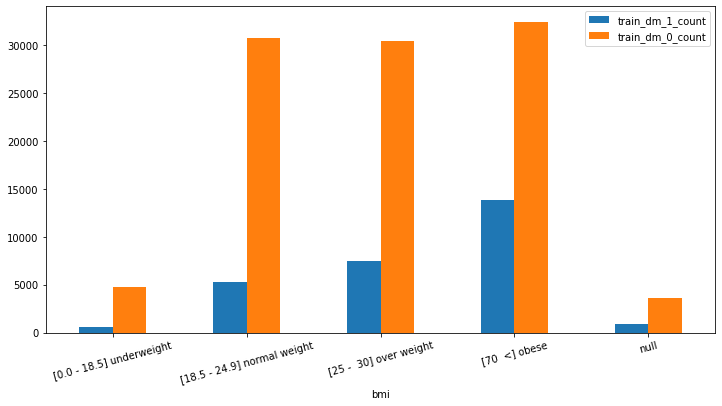

In [29]:
ax = df_bmi[['bmi','train_dm_1_count', 'train_dm_0_count']].plot.bar(x='bmi',rot=15, figsize=(12,6))

In [30]:
def label_bmi(row):
    if row['bmi'] <= 0.0:
        return  "invalid"
    elif row['bmi'] > 0.0  and row['bmi'] < 18.5:
        return "under_weight"
    elif row['bmi'] > 18.5  and row['bmi'] < 24.9:
        return "normal_weight"
    elif row['bmi'] > 25  and row['bmi'] < 30:
        return "over_weight"
    elif row['bmi'] > 30 :
        return "obese"

def negate(row, col):
    if row['diabetes_mellitus'] == 1:
        return  row[col]
    elif row['diabetes_mellitus'] == 0:
        return  row[col]*-1

df_train_ex = df_train[['bmi','gender','diabetes_mellitus']]
df_train_ex['bmi_cat'] = df_train_ex.apply(lambda row: label_bmi(row), axis=1)
df_train_ex

,bmi,gender,diabetes_mellitus,bmi_cat
0,22.73%,M,1,normal_weight
1,27.42%,F,1,over_weight
2,31.95%,F,0,obese
3,22.64%,F,0,normal_weight
4,NaN,M,0,None
...,...,...,...,...
130152,29.29%,M,0,over_weight
130153,29.65%,F,0,over_weight
130154,32.27%,M,1,obese
130155,24.41%,M,0,normal_weight


No handles with labels found to put in legend.
[0 1] ['normal_weight' 'obese' 'over_weight' 'under_weight']


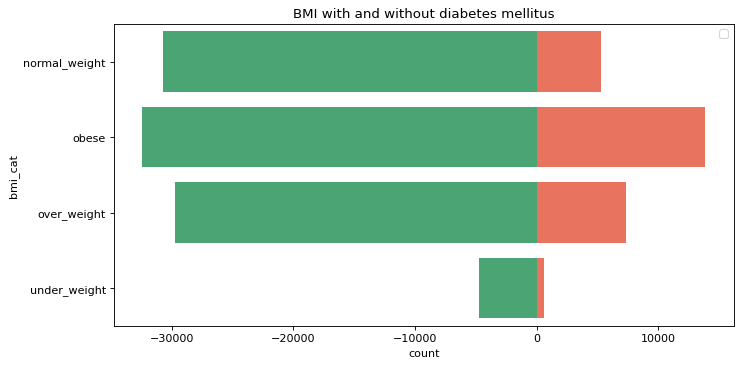

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

df_train_ex_b = df_train_ex[['bmi_cat','diabetes_mellitus']].groupby(['bmi_cat', "diabetes_mellitus"])['bmi_cat'].agg(['count'])
df_train_ex_b = df_train_ex_b.reset_index()

df_train_ex_b['count'] = df_train_ex_b.apply(lambda row: negate(row, 'count'), axis=1)

df_train_ex_b

dms = df_train_ex_b['diabetes_mellitus'].unique()
bmi_cats = df_train_ex_b['bmi_cat'].unique()

plt.figure(figsize=(10,5), dpi= 80)
colors = ['mediumseagreen', 'tomato']
print(dms, bmi_cats)
for group in dms:
    sns.barplot(x='count', y='bmi_cat', data=df_train_ex_b.loc[df_train_ex_b['diabetes_mellitus']==group, :],
            color=colors[int(group)])
plt.title("BMI with and without diabetes mellitus")
plt.legend()

In [32]:
def _expand_gender(row):
    if row['gender'] == 'M':
        return 'Male'
    elif row['gender'] == 'F':
        return 'Female'
    else:
        return 'Unknown'



df_train_ex_g = df_train[['gender','diabetes_mellitus']].groupby(['gender', "diabetes_mellitus"])['gender'].agg(['count'])
df_train_ex_g = df_train_ex_g.reset_index()

nan_rows = df_train_ex_g[df_train_ex_g['gender'].isnull()]
print(len(nan_rows))

#df_train_ex_g.fillna('Unknown', inplace=True)
gender_cats = df_train_ex_g['gender'].unique()
print(dms, gender_cats)

df_train_ex_g['gender'] = df_train_ex_g.apply(lambda row: _expand_gender(row), axis=1)
gender_cats = df_train_ex_g['gender'].unique()
print(dms, gender_cats)
df_train_ex_g['count'] = df_train_ex_g.apply(lambda row: negate(row, 'count'), axis=1)

df_train_ex_g['total'] = 'total'
#print(df_train_ex_g.info())
#df_train_ex_g['diabetes_mellitus']= 'diabetes'
print(df_train_ex_g[df_train_ex_g['diabetes_mellitus']==1]['diabetes_mellitus'])
df_train_ex_g[df_train_ex_g['diabetes_mellitus']==1]['diabetes_mellitus'] = 'diabetes'
df_train_ex_g[df_train_ex_g['diabetes_mellitus']==0]['diabetes_mellitus'] = 'no diabetes'

def change_value(row):
    if row['diabetes_mellitus'] == 1:
        return 'diabetes'
    else:
        return 'no diabetes'

df_train_ex_g['diabetes_mellitus'] = df_train_ex_g.apply(lambda row: change_value(row), axis=1)

df_train_ex_g


0
[0 1] ['F' 'M']
[0 1] ['Female' 'Male']
1    1
3    1
Name: diabetes_mellitus, dtype: int64


,gender,diabetes_mellitus,count,total
0,Female,no diabetes,-46847,total
1,Female,diabetes,12726,total
2,Male,no diabetes,-55098,total
3,Male,diabetes,15420,total


In [33]:
import plotly.express as px 

def make_positive(row):
    if row['count'] < 0:
        return row['count'] *  -1
    else:
        return row['count']

print(df_train_ex_g)
df_train_ex_g['count'] = df_train_ex_g.apply(lambda row: make_positive(row), axis=1)
print(df_train_ex_g)
print(df_train_ex_g.columns, df_train_ex_g['diabetes_mellitus'].unique() )
print(df_train_ex_g['count'].sum())
print(df_train_ex_g)

gender diabetes_mellitus  count  total
0  Female       no diabetes -46847  total
1  Female          diabetes  12726  total
2    Male       no diabetes -55098  total
3    Male          diabetes  15420  total
   gender diabetes_mellitus  count  total
0  Female       no diabetes  46847  total
1  Female          diabetes  12726  total
2    Male       no diabetes  55098  total
3    Male          diabetes  15420  total
Index(['gender', 'diabetes_mellitus', 'count', 'total'], dtype='object') ['no diabetes' 'diabetes']
130091
   gender diabetes_mellitus  count  total
0  Female       no diabetes  46847  total
1  Female          diabetes  12726  total
2    Male       no diabetes  55098  total
3    Male          diabetes  15420  total


In [34]:
px.treemap(df_train_ex_g, path=['total', 'diabetes_mellitus', 'gender'], values='count',
            color='count', color_continuous_scale='RdBu',
            color_continuous_midpoint=np.average(df_train_ex_g['count'], 
            weights=df_train_ex_g['count']))

In [35]:
plt.figure(figsize=(10,5), dpi= 80)
for group in dms:
    sns.barplot(x='count', y='gender', data=df_train_ex_g.loc[df_train_ex_g['diabetes_mellitus']==group, :],
            color=colors[int(group)])
plt.title("Gender with and without diabetes mellitus")
plt.legend()

ValueError: min() arg is an empty sequence

In [36]:
df_gender = _compare('gender', df_train_dm_1_gender, df_train_dm_0_gender, 'train_dm_1_%', 'train_dm_0_%')
df_gender

gender: train_dm_1_%: 100.0% train_dm_0_%: 100.0%


,gender,train_dm_1_count,train_dm_1_%,train_dm_0_count,train_dm_0_%
0,M,15420,54.78%,55098,54.01%
1,F,12726,45.21%,46847,45.93%
0,null,5,0.02%,61,0.06%


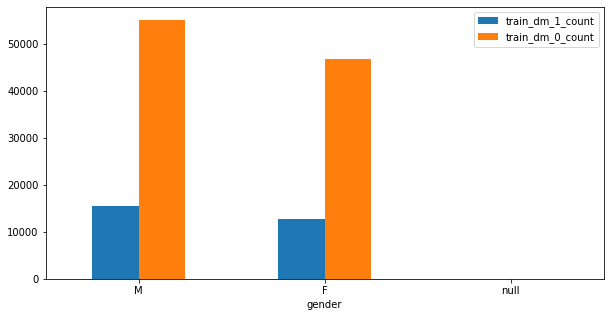

In [37]:
ax = df_gender[['gender','train_dm_1_count', 'train_dm_0_count']].plot.bar(x='gender',rot=0, figsize=(10,5))

In [38]:
df_ethnicity = _compare('ethnicity', df_train_dm_1_ethnicity, df_train_dm_0_ethnicity, 'train_dm_1_%', 'train_dm_0_%')

ethnicity: train_dm_1_%: 100.0% train_dm_0_%: 100.0%


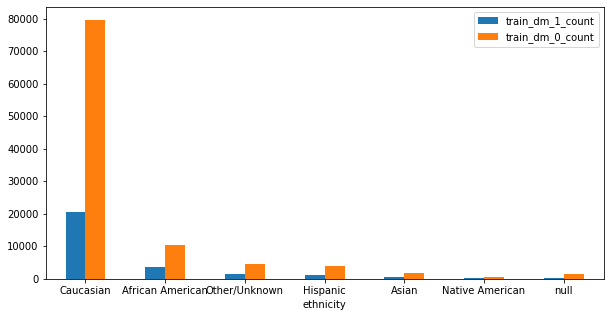

In [39]:
ax = df_ethnicity[['ethnicity','train_dm_1_count', 'train_dm_0_count']].plot.bar(x='ethnicity',rot=0, figsize=(10,5))

## Features Train DM = 1 Vs DM = 0
How are the features in the case where the dm=1 in comparison with the case where dm=0?

In [40]:
_comparedf(df_train_dm_1_age, df_train_dm_0_age, 'train_dm_1_%', 'train_dm_0_%', 'age')

age: train_dm_1_%: 100.00% train_dm_0_%: 100.00%


,age,train_dm_1_count,train_dm_1_%,train_dm_0_count,train_dm_0_%
0,"(-0.1, 0.0]",3,0.01%,27,0.03%
1,"(0.0, 15.9]",0,0.00%,0,0.00%
2,"(15.9, 20.0]",183,0.65%,1422,1.39%
3,"(20.0, 40.0]",1644,5.84%,12004,11.77%
4,"(40.0, 60.0]",7579,26.92%,29424,28.85%
5,"(60.0, 90.0]",18082,64.23%,54801,53.72%
6,"(90.0, 120.0]",0,0.00%,0,0.00%
0,null,660,2.34%,4328,4.24%


In [41]:
_compare('age', df_train_age, df_test_age, 'train_%', 'test_%')

age: train_%: 100.0% test_%: 100.0%


,age,train_count,train_%,test_count,test_%
0,"(-0.1, 0.0]",30,0.02%,0,0.00%
1,"(0.0, 15.9]",0,0.00%,0,0.00%
2,"(15.9, 20.0]",1605,1.23%,180,1.76%
3,"(20.0, 40.0]",13648,10.49%,1075,10.50%
4,"(40.0, 60.0]",37003,28.43%,2939,28.72%
5,"(60.0, 90.0]",72883,56.00%,5753,56.21%
6,"(90.0, 120.0]",0,0.00%,287,2.80%
0,null,4988,3.83%,0,0.00%


In [42]:
_comparedf(df_train_dm_1_bmi, df_train_dm_0_bmi, 'train_dm_1_%', 'train_dm_0_%', 'bmi')

bmi: train_dm_1_%: 100.00% train_dm_0_%: 100.00%


,bmi,train_dm_1_count,train_dm_1_%,train_dm_0_count,train_dm_0_%
0,[0.0 - 18.5] underweight,597,2.12%,4726,4.63%
1,[18.5 - 24.9] normal weight,5268,18.71%,30747,30.14%
2,[25 - 30] over weight,7503,26.65%,30507,29.91%
3,[70 <] obese,13868,49.26%,32451,31.81%
0,null,915,3.25%,3575,3.50%


**Observations**: 
- In the **40-60yrs** group, number of people with and without dm are almost same.
- In the **60-90yrs** group, number of people with dm are more than without dm.
- In the **Obese** category, number people who have dm is more than those without dm
- In other age and bmi categories, number of people with dm is lesser than those without dm.
- The distribution of genders with and without dm is similar.
- Convert categorical features - gender, ethnicity and bmi into dummy variables

In [43]:
_compare('bmi', df_train_bmi, df_test_bmi, 'train_%', 'test_%')

bmi: train_%: 100.0% test_%: 100.0%


,bmi,train_count,train_%,test_count,test_%
0,[0.0 - 18.5] underweight,5323,4.09%,388,3.79%
1,[18.5 - 24.9] normal weight,36015,27.67%,2651,25.90%
2,[25 - 30] over weight,38010,29.20%,2863,27.98%
3,[70 <] obese,46319,35.59%,3317,32.41%
0,null,4490,3.45%,1015,9.92%


## Features Train Vs Test


In [44]:
_comparedf(df_train_age, df_test_age, 'train_%', 'test_%', 'age')

age: train_%: 100.00% test_%: 100.00%


,age,train_count,train_%,test_count,test_%
0,"(-0.1, 0.0]",30,0.02%,0,0.00%
1,"(0.0, 15.9]",0,0.00%,0,0.00%
2,"(15.9, 20.0]",1605,1.23%,180,1.76%
3,"(20.0, 40.0]",13648,10.49%,1075,10.50%
4,"(40.0, 60.0]",37003,28.43%,2939,28.72%
5,"(60.0, 90.0]",72883,56.00%,5753,56.21%
6,"(90.0, 120.0]",0,0.00%,287,2.80%
0,null,4988,3.83%,0,0.00%


In [45]:
_compare('gender', df_train_gender, df_test_gender, 'train_%', 'test_%')

gender: train_%: 100.0% test_%: 100.0%


,gender,train_count,train_%,test_count,test_%
0,M,70518,54.18%,5525,53.99%
1,F,59573,45.77%,4704,45.96%
0,null,66,0.05%,0,0.00%


In [46]:
_compare('ethnicity', df_train_ethnicity, df_test_ethnicity, 'train_%', 'test_%')

ethnicity: train_%: 100.0% test_%: 100.0%


,ethnicity,train_count,train_%,test_count,test_%
0,Caucasian,100236,77.01%,7939,77.57%
1,African American,13911,10.69%,931,9.10%
2,Other/Unknown,6261,4.81%,435,4.25%
3,Hispanic,5049,3.88%,471,4.60%
4,Asian,2198,1.69%,171,1.67%
5,Native American,915,0.70%,83,0.81%
0,null,1587,1.22%,0,0.00%


In [47]:
_comparedf(df_train_bmi, df_test_bmi, 'train_%', 'test_%', 'bmi')


bmi: train_%: 100.00% test_%: 100.00%


,bmi,train_count,train_%,test_count,test_%
0,[0.0 - 18.5] underweight,5323,4.09%,388,3.79%
1,[18.5 - 24.9] normal weight,36015,27.67%,2651,25.90%
2,[25 - 30] over weight,38010,29.20%,2863,27.98%
3,[70 <] obese,46319,35.59%,3317,32.41%
0,null,4490,3.45%,1015,9.92%


In [48]:
_comparedf(df_train_gender, df_test_gender, 'train_%', 'test_%', 'gender')

gender: train_%: 100.00% test_%: 99.95%


,gender,train_count,train_%,test_count,test_%
0,M,70518,54.18%,5525,53.99%
1,F,59573,45.77%,4704,45.96%
0,null,66,0.05%,0,0.00%


In [49]:
_comparedf(df_train_ethnicity, df_test_ethnicity, 'train_%', 'test_%', 'ethnicity')

ethnicity: train_%: 100.00% test_%: 98.01%


,ethnicity,train_count,train_%,test_count,test_%
0,Caucasian,100236,77.01%,7939,77.57%
1,African American,13911,10.69%,931,9.10%
2,Other/Unknown,6261,4.81%,435,4.25%
3,Hispanic,5049,3.88%,471,4.60%
4,Asian,2198,1.69%,171,1.67%
5,Native American,915,0.70%,83,0.81%
0,null,1587,1.22%,0,0.00%


In [50]:
df_age_invalid = df_train[df_train['age']==0.0]
age_null = df_age_invalid.isnull().sum().sum()
age_total = df_age_invalid.shape[0] * df_age_invalid.shape[1]
print(f"Invalid age: Rows: {df_age_invalid.shape[0]} % null values: {100 * age_null/age_total:0.2f}%")
print(df_age_invalid)

Invalid age: Rows: 30 % null values: 74.90%
        Unnamed: 0  encounter_id  hospital_id   age    bmi  elective_surgery  \
10394        10395        273814           85 0.00%    NaN                 0   
10953        10954        178066           85 0.00%    NaN                 0   
12376        12377        209548          169 0.00%    NaN                 0   
12538        12539        266259          177 0.00% 34.56%                 0   
13298        13299        214791          177 0.00% 26.16%                 0   
14122        14123        255197          177 0.00% 21.34%                 0   
25765        25766        196004          161 0.00%    NaN                 0   
34590        34591        198926           70 0.00% 16.70%                 0   
35300        35301        230255           70 0.00% 42.66%                 0   
35429        35430        218838           70 0.00% 34.07%                 0   
36314        36315        254103           70 0.00% 34.77%                 0

Almost 70% of the values in the rows where age is null have null values. We can remove these 30 rows.

**Presence of invalid and missing values and handling :**
- **age**:
    - In the training dataset, there are 30 invalid ages. Most (70%) values are missing. Remove these rows.
    - In the training dataset, there are null values for age. Handling?
- **gender**: 
    - In both training and test datasets, there are null values for gender. Fill "Unknown"
    - Convert the gender to dummy variables
- **ethnicity**: 
    - In both training and test datasets, there are null values for ethnicity. Fill "Unkown"
    - Convert the ethnicity to dummy variables
- **weight**: Fill Average weight of the age, gender & ethnicity
- **height**: Fill Average height of the age, gender & ethnicity
- **bmi**: 
    - Derived variable from weight and height
    - In both training and test datasets, there are null values for bmi. 
    - weight and height can be imputed using age, gender and ethnicity
        - training: Around 194 rows are null. Remove these rows?
        - testing: All dependent columns have values
    - Extract non-null rows of age, gender, ethnicity, weight, height and make a linear regression
    - Calculate bmi based on  weight and height. Here, there 3 possibilities - weight only is present, height only is present, both weight and height is not present.
    -  Should weight and height be replaced only with bmi?

- Convert categorical features - gender, ethnicity and bmi into dummy variables

**Findings**
- Distribution of age across categories is similar for training and Unlabeled datasets
- The distribution of bmi across categories is similar in training and Unlabeled data sets

Remove rows where age has invalid values 

In [51]:
df_train_up = df_train.drop(df_train[df_train['age']==0.0].index)
print(f"{df_train.shape[0]} --> {df_train_up.shape[0]}")

130157 --> 130127


In [52]:
df_train_demo1 = df_train_up[['encounter_id', 'age', 'gender', 'ethnicity', 'weight', 'height', 'bmi']]
df_train_demo1

,encounter_id,age,gender,ethnicity,weight,height,bmi
0,214826,68.00%,M,Caucasian,73.90%,180.30%,22.73%
1,246060,77.00%,F,Caucasian,70.20%,160.00%,27.42%
2,276985,25.00%,F,Caucasian,95.30%,172.70%,31.95%
3,262220,81.00%,F,Caucasian,61.70%,165.10%,22.64%
4,201746,19.00%,M,Caucasian,NaN,188.00%,NaN
...,...,...,...,...,...,...,...
130152,164758,50.00%,M,Caucasian,90.00%,175.30%,29.29%
130153,197653,79.00%,F,Caucasian,78.40%,162.60%,29.65%
130154,219719,73.00%,M,African American,102.00%,177.80%,32.27%
130155,222562,81.00%,M,Caucasian,83.90%,185.40%,24.41%


In [88]:
#df_weight = df_train_demo1.groupby('gender')['gender'].count(['age']) This workds
# df_age = df.groupby(AGE_BINS)['age'].agg(['count'])
df_weight = df_train_demo1.groupby([AGE_BINS(df_train_demo1), 'gender', 'ethnicity'])['weight'].agg(['mean'])
df_weight.reset_index()


,age,gender,ethnicity,mean
0,"(-0.1, 0.0]",F,African American,NaN
1,"(-0.1, 0.0]",F,Asian,NaN
2,"(-0.1, 0.0]",F,Caucasian,NaN
3,"(-0.1, 0.0]",F,Hispanic,NaN
4,"(-0.1, 0.0]",F,Native American,NaN
...,...,...,...,...
79,"(90.0, 120.0]",M,Asian,NaN
80,"(90.0, 120.0]",M,Caucasian,NaN
81,"(90.0, 120.0]",M,Hispanic,NaN
82,"(90.0, 120.0]",M,Native American,NaN


In [89]:
print(df_weight.columns)

Index(['mean'], dtype='object')


In [90]:
df_weight.iloc[[40]]

,,,mean
age,gender,ethnicity,
"(20.0, 40.0]",F,Native American,88.79%


In [91]:
 pd.pivot_table(df_weight, values='mean', index=['age', 'gender'],columns=['ethnicity'], aggfunc=np.mean)

ethnicity            African American  Asian  Caucasian  Hispanic  \
age          gender                                                 
(15.9, 20.0] F                 75.19% 63.94%     67.38%    70.11%   
             M                 83.43% 68.34%     76.72%    73.89%   
(20.0, 40.0] F                 88.67% 65.93%     79.03%    74.15%   
             M                 94.40% 79.11%     89.58%    87.59%   
(40.0, 60.0] F                 89.34% 66.69%     82.77%    78.22%   
             M                 93.47% 76.88%     95.49%    89.32%   
(60.0, 90.0] F                 80.99% 59.61%     75.18%    70.94%   
             M                 85.80% 69.08%     89.01%    80.09%   

ethnicity            Native American  Other/Unknown  
age          gender                                  
(15.9, 20.0] F                74.47%         65.64%  
             M                82.97%         75.71%  
(20.0, 40.0] F                88.79%         76.64%  
             M                95.59%         88.02%  
(40.0, 60.0] F                86.59%         79.35%  
             M                96.64%         87.79%  
(60.0, 90.0] F                78.55%         71.47%  
             M                83.60%         81.69%

In [ ]:

df_train_nana_weight = df_train_demo1[df_train_demo1['weight'].isnull()]
df_train_nana_weight

===========================X===========================X===========================X===========================X

*Work in Progress*

===========================X===========================X===========================X===========================X

- Combine features - ratio, difference 

In [ ]:
df_train.groupby(['hospital_id']).count()['encounter_id'].sort_values()

In [ ]:
df_train.loc[df_train['hospital_id']==4]

In [ ]:
df_train.groupby('icu_id')['icu_id'].agg(['count']).sort_values(by = 'count', ascending=False)

In [ ]:
df_train['bmi_calc'] = df['weight']/(df['height']/100)**2

In [ ]:
df_bmi = df_train[['weight', 'height', 'bmi']]
df_bmi_1  = df_bmi[df_bmi.isna().any(axis=1)]

In [ ]:
df_bmi_1

In [ ]:
# encounter_ids are unique and there are no repeats
df_temp = df.groupby(['encounter_id'])['encounter_id'].count().sort_values(ascending=False)
#df_temp = df_temp.rename(columns = {'encounter_id':'count'})
#df_temp['%'] = 100 * df_temp['count'] / df_temp['count'].sum()
#pd.options.display.float_format = '{:.2f}%'.format
print(df_temp)

In [ ]:
def getAllValues(df, col):
    df_temp = df.groupby([col]).count()['encounter_id'].sort_values(ascending=False).reset_index()
    df_temp = df_temp.rename(columns = {'encounter_id':'count'})
    df_temp['%'] = 100 * df_temp['count'] / df_temp['count'].sum()
    print(df_temp)

In [ ]:
# Columns - string type
for  col in ['ethnicity', 'gender', 'hospital_admit_source', 'icu_admit_source', 'icu_type', 'icu_stay_type']:
    getAllValues(df, col)
    getAllValues(df_test, col)
    print()

In [ ]:
# Columns - binary type
for col in ['elective_surgery', 'readmission_status', 'diabetes_mellitus' ]:
    getAllValues(df, col)	
    if col != 'diabetes_mellitus':
        getAllValues(df_test, col)
    print()

In [ ]:
# Columns - nan data

nan_counts = []
nan_counts_percent = []
for col in df.columns:
    total = df[col].count()
    nan_rows = len(df[df[col].isnull()])
    nan_counts.append(nan_rows)
    nan_counts_percent.append(100 * nan_rows/(total+nan_rows))

In [ ]:
df_nan = pd.DataFrame({'Variable Name':df.columns, 'nan_counts':nan_counts, '%':nan_counts_percent})
df_nan = df_nan.sort_values('nan_counts', ascending = False)
df_nan['%'] = df_nan['%'].map('{:,.1f}%'.format)
print(df_nan)
df_nan.to_csv("nan_data.csv")
print(df_nan.shape[0])

In [ ]:
# Rows with nan data
df_nan = df[df.isna().any(axis=1)]
print (f"Rows with nan values: {100 * df_nan.shape[0]/df.shape[0]:.2f}%")

In [ ]:
df_dict = pd.read_csv("data/DataDictionaryWiDS2021.csv")
print(df_dict[['Variable Name', 'Category', 'Data Type']])
print(df_dict.shape[0])

In [ ]:
df_data_desc = pd.merge(df_nan, df_dict, on="Variable Name")
df_data_desc = df_data_desc.sort_values(by=['Category','Variable Name'])
df_data_desc.to_csv("datadesc.csv")

In [ ]:
df[['apache_2_diagnosis', 'diabetes_mellitus']].corr()

In [ ]:
from sklearn.linear_model import LinearRegression
import numpy as np
X = df[['arf_apache']]
Y = df['diabetes_mellitus']
slm = LinearRegression()
np.set_printoptions(precision=2)
slm.fit(X,Y)

In [ ]:
Yhat =slm_hm.predict(X_hm)